# High-level overview:
The purpose of the Sparkify project is to develop a machine learning model to predict customer churn for the Sparkify music streaming service. Customer churn refers to the phenomenon where customers discontinue their subscription or stop using the service. By predicting churn, Sparkify can take proactive measures to retain customers and improve user engagement. The project involves analyzing a dataset of user activity logs, applying data preprocessing techniques, conducting exploratory data analysis, and implementing machine learning models to predict churn.

In [2]:
# import libraries
import pyspark
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline, PipelineModel
import pyspark.ml.classification as cl
import pyspark.ml.evaluation as ev
import pyspark.ml.feature as ft
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import boto3
import botocore

In [3]:
pyspark.__version__

'3.4.1'

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1689250207780'),
 ('spark.driver.port', '43907'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.rdd.compress', 'True'),
 ('spark.app

In [5]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [6]:
#@title Insert your AWS key id and secret key here.

boto3.setup_default_session(aws_access_key_id='',
                            aws_secret_access_key='')


In [7]:
s3 = boto3.resource('s3')
bucket_name = 'udacity-dsnd'
key = 'sparkify/sparkify_event_data.json'
local_file_path = '/content/sparkify_event_data.json'  # Specify the local path where you want to save the file

try:
    s3.Bucket(bucket_name).download_file(key, local_file_path)
    print("File downloaded successfully!")
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise


File downloaded successfully!


In [8]:
dataset = spark.read.json(local_file_path)

In [9]:
dataset.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
dataset.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [11]:
cols=['userId', 'page','location','userAgent','gender','artist','song']

In [12]:
dataset=dataset.select(cols)

In [13]:
dataset=dataset.dropna(how = "any", subset = ["userId",])

In [14]:
dataset=dataset.fillna("None")

In [15]:
isdigit=F.udf(lambda str:str.isdigit(),T.BooleanType())

In [16]:
dataset=dataset.filter(isdigit(dataset.userId))

In [17]:
dataset.count()

278154

Set the type of `usedId` to integer.

In [18]:
dataset=dataset.withColumn("userId",dataset.userId.cast('long'))

In [19]:
dataset.persist()

DataFrame[userId: bigint, page: string, location: string, userAgent: string, gender: string, artist: string, song: string]

# Description of Input Data:
The dataset used for the project consists of user activity logs from Sparkify. It includes information such as timestamps, user interactions (e.g., song plays, likes, and dislikes), demographic data (e.g., gender, location), and other relevant features. The variables in the dataset play a crucial role in predicting churn. For example, the frequency of user interactions, the length of active sessions, and the user's subscription level could be indicative of potential churn. Exploring and understanding these variables helps in building an effective churn prediction model.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#Strategy for solving the problem:
The overall approach to solving the churn prediction problem involves several key steps. Initially, the dataset is loaded and preprocessed to handle missing values, outliers, and data inconsistencies. Exploratory data analysis is conducted to gain insights into the data and identify patterns or trends related to churn. Feature engineering techniques are applied to extract relevant features from the dataset. Classifiers are trained and evaluated for their predictive performance. The chosen model is then fine-tuned through hyperparameter optimization to improve its effectiveness in predicting churn.

# Discussion of the expected solution:
The proposed solution typically involves developing a machine learning pipeline for churn prediction. The pipeline includes data preprocessing steps, such as handling missing values, followed by feature engineering techniques to extract meaningful features. The preprocessed data is then used to train and evaluate different machine learning models. The best-performing model is selected based on evaluation metrics, such as F1 score, precision, recall, and AUC-ROC. The final model is deployed to predict churn for new, unseen data.

# Data Preprocessing:
Data preprocessing steps include handling missing values, removing duplicates, addressing outliers, and performing feature engineering. Missing values are either imputed or discarded, duplicates are dropped to ensure data integrity, outliers are handled based on their impact on the analysis, and feature engineering techniques, such as creating aggregate features or transforming variables, are applied to extract meaningful information that improves the predictive power of the model.

In [20]:
dataset.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In order to look for the `churn`s, we will group the data by `userId` and collect all the `page`s as `history`.

In [21]:
history=dataset.select(['userId','page']).groupby('userId').agg(F.collect_list('page').alias('history'))

In [22]:
history.show()

+------+--------------------+
|userId|             history|
+------+--------------------+
|     2|[NextSong, NextSo...|
|     3|[NextSong, NextSo...|
|     4|[NextSong, NextSo...|
|     5|[Home, NextSong, ...|
|     6|[NextSong, NextSo...|
|     7|[NextSong, NextSo...|
|     8|[Home, NextSong, ...|
|     9|[Home, NextSong, ...|
|    10|[NextSong, NextSo...|
|    11|[NextSong, Roll A...|
|    12|[NextSong, NextSo...|
|    13|[NextSong, Settin...|
|    14|[NextSong, Downgr...|
|    15|[NextSong, NextSo...|
|    16|[NextSong, Add to...|
|    17|[NextSong, NextSo...|
|    18|[Home, NextSong, ...|
|    19|[NextSong, NextSo...|
|    20|[NextSong, NextSo...|
|    21|[Home, NextSong, ...|
+------+--------------------+
only showing top 20 rows



Then, we define `churn` to be `1` if `{'Cancellation Confirmation','Submit Downgrade'}` is subset of the `history` and `0` otherwise.

In [23]:
issubset = F.udf(lambda l: int('Cancellation Confirmation' in l), T.IntegerType())

In [24]:
history=history.withColumn("churn",issubset(history.history))

In [25]:
history.show()

+------+--------------------+-----+
|userId|             history|churn|
+------+--------------------+-----+
|     2|[NextSong, NextSo...|    0|
|     3|[NextSong, NextSo...|    1|
|     4|[NextSong, NextSo...|    0|
|     5|[Home, NextSong, ...|    0|
|     6|[NextSong, NextSo...|    0|
|     7|[NextSong, NextSo...|    0|
|     8|[Home, NextSong, ...|    0|
|     9|[Home, NextSong, ...|    0|
|    10|[NextSong, NextSo...|    0|
|    11|[NextSong, Roll A...|    0|
|    12|[NextSong, NextSo...|    1|
|    13|[NextSong, Settin...|    0|
|    14|[NextSong, Downgr...|    0|
|    15|[NextSong, NextSo...|    0|
|    16|[NextSong, Add to...|    0|
|    17|[NextSong, NextSo...|    1|
|    18|[Home, NextSong, ...|    1|
|    19|[NextSong, NextSo...|    0|
|    20|[NextSong, NextSo...|    0|
|    21|[Home, NextSong, ...|    0|
+------+--------------------+-----+
only showing top 20 rows



We compute now the length of the history as an indicator of user activity.

In [26]:
Len=F.udf(len,T.IntegerType())

In [27]:
history=history.withColumn("nHist",Len("history"))

In [28]:
history.show()

+------+--------------------+-----+-----+
|userId|             history|churn|nHist|
+------+--------------------+-----+-----+
|     2|[NextSong, NextSo...|    0|  899|
|     3|[NextSong, NextSo...|    1|  254|
|     4|[NextSong, NextSo...|    0| 2442|
|     5|[Home, NextSong, ...|    0|  218|
|     6|[NextSong, NextSo...|    0| 3761|
|     7|[NextSong, NextSo...|    0|  201|
|     8|[Home, NextSong, ...|    0|  334|
|     9|[Home, NextSong, ...|    0| 3191|
|    10|[NextSong, NextSo...|    0|  795|
|    11|[NextSong, Roll A...|    0|  848|
|    12|[NextSong, NextSo...|    1| 1064|
|    13|[NextSong, Settin...|    0| 1654|
|    14|[NextSong, Downgr...|    0| 1432|
|    15|[NextSong, NextSo...|    0| 2278|
|    16|[NextSong, Add to...|    0|  819|
|    17|[NextSong, NextSo...|    1| 1102|
|    18|[Home, NextSong, ...|    1|  513|
|    19|[NextSong, NextSo...|    0|  259|
|    20|[NextSong, NextSo...|    0| 2195|
|    21|[Home, NextSong, ...|    0|  589|
+------+--------------------+-----

In [29]:
history.agg(F.min("nHist"),F.max("nHist")).show()

+----------+----------+
|min(nHist)|max(nHist)|
+----------+----------+
|         6|      9632|
+----------+----------+



In [30]:
history=history.drop("nHist")

We look for the person `trajectory`, we will group the data by `userId` and collect all the `location`s.

In [31]:
trajectory=dataset.select(['userId','location']).groupby('userId').agg(F.collect_list('location').alias('trajectory'))

In [32]:
lenSet=F.udf(lambda x:len(set(x)),T.IntegerType())

In [33]:
trajectory=trajectory.withColumn("nLoc",lenSet("trajectory"))

In [34]:
trajectory.agg(F.max("nLoc")).show()

+---------+
|max(nLoc)|
+---------+
|        1|
+---------+



We have only one location person. So we reduce all the list for the first element.

In [35]:
trajectory=trajectory.drop("nLoc")

In [36]:
reduction=F.udf(lambda x:x[0])

In [37]:
trajectory=trajectory.withColumn("location",reduction("trajectory")).drop("trajectory")

In [38]:
trajectory.show()

+------+--------------------+
|userId|            location|
+------+--------------------+
|     2|         Raleigh, NC|
|     3|         Bozeman, MT|
|     4|Baltimore-Columbi...|
|     5|Phoenix-Mesa-Scot...|
|     6|Houston-The Woodl...|
|     7|Seattle-Tacoma-Be...|
|     8|    St. Louis, MO-IL|
|     9|Boston-Cambridge-...|
|    10|          Laurel, MS|
|    11|Providence-Warwic...|
|    12|Los Angeles-Long ...|
|    13|Philadelphia-Camd...|
|    14|        Syracuse, NY|
|    15|      Morgantown, WV|
|    16|   Winston-Salem, NC|
|    17|Philadelphia-Camd...|
|    18|  Kansas City, MO-KS|
|    19|          Dayton, OH|
|    20|Miami-Fort Lauder...|
|    21|        Kankakee, IL|
+------+--------------------+
only showing top 20 rows



In [39]:
trajectory.select('location').distinct().count()

114

We fo the same for `userAgent`.

In [40]:
userAgents=dataset.select(['userId','userAgent']).groupby('userId').agg(F.collect_list('userAgent').alias('userAgents'))

In [41]:
userAgents=userAgents.withColumn("nAgent",lenSet("userAgents"))

In [42]:
userAgents.agg(F.max("nAgent")).show()

+-----------+
|max(nAgent)|
+-----------+
|          1|
+-----------+



We have only one browser person. So we reduce all the list for the first element.

In [43]:
userAgents=userAgents.drop("nAgent")

In [44]:
userAgents=userAgents.withColumn("userAgent",reduction("userAgents")).drop("userAgents")

In [45]:
userAgents.show()

+------+--------------------+
|userId|           userAgent|
+------+--------------------+
|     2|"Mozilla/5.0 (Win...|
|     3|"Mozilla/5.0 (Win...|
|     4|Mozilla/5.0 (Wind...|
|     5|"Mozilla/5.0 (Win...|
|     6|"Mozilla/5.0 (Mac...|
|     7|Mozilla/5.0 (Wind...|
|     8|"Mozilla/5.0 (Win...|
|     9|"Mozilla/5.0 (Win...|
|    10|"Mozilla/5.0 (Mac...|
|    11|Mozilla/5.0 (Wind...|
|    12|Mozilla/5.0 (Wind...|
|    13|"Mozilla/5.0 (iPh...|
|    14|Mozilla/5.0 (Maci...|
|    15|"Mozilla/5.0 (Win...|
|    16|"Mozilla/5.0 (Win...|
|    17|Mozilla/5.0 (Wind...|
|    18|"Mozilla/5.0 (Mac...|
|    19|Mozilla/5.0 (Wind...|
|    20|"Mozilla/5.0 (Win...|
|    21|Mozilla/5.0 (Wind...|
+------+--------------------+
only showing top 20 rows



In [46]:
sub=F.udf(lambda x:re.sub('"',"",x),T.StringType())

In [47]:
userAgents=userAgents.withColumn("userAgent",sub("userAgent"))

In [48]:
userAgents.select('userAgent').distinct().count()

56

We continue with same logic for the `gender`.

In [49]:
dataset.select('gender').distinct().count()

2

In [50]:
genders=dataset.select(['userId','gender']).groupby('userId').agg(F.collect_list('gender').alias('genders'))

In [51]:
genders=genders.withColumn("nGender",lenSet("genders"))

In [52]:
genders.agg(F.max("nGender")).show()

+------------+
|max(nGender)|
+------------+
|           1|
+------------+



In [53]:
genders=genders.drop("nGender")

In [54]:
genders=genders.withColumn("gender",reduction("genders")).drop("genders")

In [55]:
genders.show()

+------+------+
|userId|gender|
+------+------+
|     2|     F|
|     3|     M|
|     4|     M|
|     5|     M|
|     6|     M|
|     7|     M|
|     8|     F|
|     9|     M|
|    10|     M|
|    11|     F|
|    12|     F|
|    13|     F|
|    14|     M|
|    15|     M|
|    16|     F|
|    17|     F|
|    18|     M|
|    19|     F|
|    20|     F|
|    21|     M|
+------+------+
only showing top 20 rows



For the artist and song, we will keep the wole list.

In [56]:
dataset.select('artist').distinct().count()

17656

In [57]:
artists=dataset.select(['userId','artist']).groupby('userId').agg(F.collect_list('artist').alias('artists'))

In [58]:
artists=artists.withColumn("nArtist",lenSet("artists"))

In [59]:
artists.agg(F.max("nArtist")).show()

+------------+
|max(nArtist)|
+------------+
|        3545|
+------------+



In [60]:
artists=artists.drop("nArtist")

In [61]:
artists.show()

+------+--------------------+
|userId|             artists|
+------+--------------------+
|    26|[None, Aerosmith,...|
|    29|[None, David Holm...|
|    65|[None, None, None...|
|    19|[Red, Verona, Sea...|
|    54|[A Day To Remembe...|
|   112|[None, None, Pear...|
|   113|[Paradise Lost, N...|
|   155|[None, The Black ...|
|    22|[None, None, None...|
|     7|[None, Harmonia, ...|
|    77|[None, Todd Barry...|
|    34|[None, Lucero, Co...|
|   126|[None, Jason Reev...|
|    50|[None, Owl City, ...|
|    94|[None, Phoenix, C...|
|   149|[None, Spineshank...|
|   110|[None, Maelo Ruiz...|
|    57|[Dr Feelgood, Das...|
|   136|[The Rolling Ston...|
|   144|[None, None, Alis...|
+------+--------------------+
only showing top 20 rows



In [62]:
dataset.select('song').distinct().count()

58481

In [63]:
songs=dataset.select(['userId','song']).groupby('userId').agg(F.collect_list('song').alias('songs'))

In [64]:
songs=songs.withColumn("nSong",lenSet("songs"))

In [65]:
songs.agg(F.max("nSong")).show()

+----------+
|max(nSong)|
+----------+
|      5947|
+----------+



In [66]:
songs=songs.drop("nSong")

In [67]:
songs.show()

+------+--------------------+
|userId|               songs|
+------+--------------------+
|    26|[None, Walk This ...|
|    29|[None, Gritty Sha...|
|    65|[None, None, None...|
|    19|[Ordinary World, ...|
|    54|[Since U Been Gon...|
|   112|[None, None, Rear...|
|   113|[Nuclear Abominat...|
|   155|[None, Busted, No...|
|    22|[None, None, None...|
|     7|[None, Sehr kosmi...|
|    77|[None, Sugar Ray ...|
|    34|[None, Cass, Spee...|
|   126|[None, Wishing We...|
|    50|[None, Meteor Sho...|
|    94|[None, If It's No...|
|   149|[None, Smothered ...|
|   110|[None, Te Va A Do...|
|    57|[That Ain't The W...|
|   136|[Rocks Off, Sweet...|
|   144|[None, None, I Gi...|
+------+--------------------+
only showing top 20 rows



Now, we combine all together.

In [68]:
del dataset
data=history.orderBy('userId')
del history

for temp in [trajectory,userAgents,genders,artists,songs]:
    data=data.join(temp,'userId')

del trajectory,userAgents,genders,artists,songs,temp

# EDA:
During exploratory data analysis, statistical summaries, and analytical techniques are employed to uncover patterns and insights in the dataset. This includes analyzing the distribution of churned and non-churned users, exploring correlations between different variables, examining temporal trends, and identifying any significant factors related to churn. EDA helps in understanding the characteristics of churned users and provides insights that inform feature engineering and model selection.

In [69]:
data.show(vertical=True)

-RECORD 0-------------------------
 userId    | 2                    
 history   | [NextSong, NextSo... 
 churn     | 0                    
 location  | Raleigh, NC          
 userAgent | Mozilla/5.0 (Wind... 
 gender    | F                    
 artists   | [The Offspring, S... 
 songs     | [Hit That, Enjoy ... 
-RECORD 1-------------------------
 userId    | 3                    
 history   | [NextSong, NextSo... 
 churn     | 1                    
 location  | Bozeman, MT          
 userAgent | Mozilla/5.0 (Wind... 
 gender    | M                    
 artists   | [Kollaa KestÃÂ¤Ã... 
 songs     | [Musti Sotakoira ... 
-RECORD 2-------------------------
 userId    | 4                    
 history   | [NextSong, NextSo... 
 churn     | 0                    
 location  | Baltimore-Columbi... 
 userAgent | Mozilla/5.0 (Wind... 
 gender    | M                    
 artists   | [The J.B.'s, La M... 
 songs     | [Pass The Peas, V... 
-RECORD 3-------------------------
 userId    | 5      

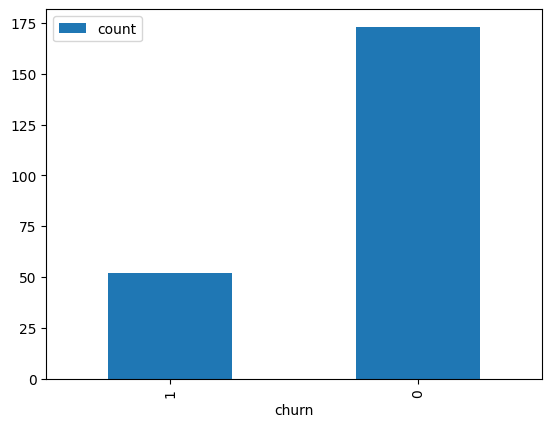

In [70]:
data.groupby("churn").count().toPandas().set_index("churn").plot.bar();

Users who do not churn are three times more numerous than those who do.

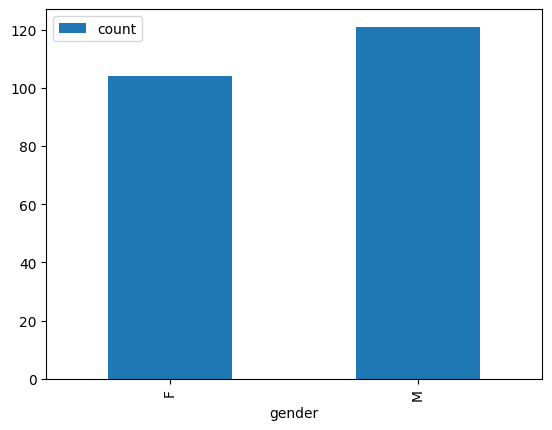

In [71]:
data.groupby("gender").count().toPandas().set_index("gender").plot.bar();

We have almost an equal number of female and male users.

In [72]:
data.groupby(["churn","gender"]).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    1|     F|   20|
|    0|     M|   89|
|    1|     M|   32|
|    0|     F|   84|
+-----+------+-----+



In [73]:
data.groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL|    1|
|Atlantic City-Ham...|    1|
|Deltona-Daytona B...|    1|
|San Diego-Carlsba...|    3|
|Cleveland-Elyria, OH|    1|
|Kingsport-Bristol...|    1|
|New Haven-Milford...|    3|
|Birmingham-Hoover...|    1|
|  Corpus Christi, TX|    1|
|         Dubuque, IA|    1|
|Las Vegas-Henders...|    3|
|Indianapolis-Carm...|    2|
|Seattle-Tacoma-Be...|    2|
|          Albany, OR|    1|
|   Winston-Salem, NC|    1|
|Los Angeles-Long ...|   16|
|     Bakersfield, CA|    1|
|Minneapolis-St. P...|    2|
|San Francisco-Oak...|    2|
|Phoenix-Mesa-Scot...|    7|
+--------------------+-----+
only showing top 20 rows



In [74]:
data.groupby(["churn","location"]).count().show()

+-----+--------------------+-----+
|churn|            location|count|
+-----+--------------------+-----+
|    0|Seattle-Tacoma-Be...|    2|
|    0|    St. Louis, MO-IL|    5|
|    1|         Bozeman, MT|    1|
|    1|          Albany, OR|    1|
|    0|      Morgantown, WV|    1|
|    1|           Flint, MI|    2|
|    0|San Diego-Carlsba...|    2|
|    0|       Fairbanks, AK|    1|
|    0|San Francisco-Oak...|    1|
|    0|Minneapolis-St. P...|    2|
|    0|Los Angeles-Long ...|   13|
|    0|Virginia Beach-No...|    1|
|    0|        Syracuse, NY|    2|
|    0|New York-Newark-J...|   10|
|    0|Riverside-San Ber...|    1|
|    0|      Montgomery, AL|    1|
|    1|Houston-The Woodl...|    1|
|    0|Hagerstown-Martin...|    1|
|    1|Albany-Schenectad...|    1|
|    0|Kingsport-Bristol...|    1|
+-----+--------------------+-----+
only showing top 20 rows



In [75]:
data.groupby("userAgent").count().show()

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|Mozilla/5.0 (Wind...|   24|
|Mozilla/5.0 (Wind...|    7|
|Mozilla/5.0 (Maci...|    1|
|Mozilla/5.0 (X11;...|    1|
|Mozilla/5.0 (Maci...|    2|
|Mozilla/5.0 (X11;...|    4|
|Mozilla/5.0 (Wind...|    1|
|Mozilla/5.0 (Maci...|    1|
|Mozilla/5.0 (Maci...|   12|
|Mozilla/5.0 (Wind...|    1|
|Mozilla/5.0 (Wind...|    4|
|Mozilla/5.0 (comp...|    3|
|Mozilla/5.0 (Maci...|    9|
|Mozilla/5.0 (Wind...|    4|
|Mozilla/5.0 (Wind...|   18|
|Mozilla/5.0 (Maci...|    1|
|Mozilla/5.0 (X11;...|    2|
|Mozilla/5.0 (comp...|    1|
|Mozilla/5.0 (comp...|    1|
|Mozilla/5.0 (Maci...|    1|
+--------------------+-----+
only showing top 20 rows



In [76]:
data.groupby(["churn","userAgent"]).count().show()

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    1|Mozilla/5.0 (Maci...|    1|
|    0|Mozilla/5.0 (Wind...|    1|
|    0|Mozilla/5.0 (iPho...|    4|
|    0|Mozilla/5.0 (X11;...|    1|
|    0|Mozilla/5.0 (Maci...|    1|
|    1|Mozilla/5.0 (Wind...|    1|
|    0|Mozilla/5.0 (Maci...|    1|
|    0|Mozilla/5.0 (Wind...|    5|
|    0|Mozilla/5.0 (X11;...|    1|
|    0|Mozilla/5.0 (Wind...|    2|
|    0|Mozilla/5.0 (Wind...|    1|
|    1|Mozilla/5.0 (Maci...|    1|
|    0|Mozilla/5.0 (Maci...|    1|
|    1|Mozilla/5.0 (Wind...|    1|
|    0|Mozilla/5.0 (Maci...|    1|
|    0|Mozilla/5.0 (Wind...|    3|
|    0|Mozilla/5.0 (Maci...|    9|
|    0|Mozilla/5.0 (Wind...|    9|
|    0|Mozilla/5.0 (comp...|    3|
|    0|Mozilla/5.0 (Wind...|    2|
+-----+--------------------+-----+
only showing top 20 rows



In [77]:
@F.udf(returnType=T.ArrayType(T.StringType()))
def remove(x):

    while True:
        try:
            x.remove('Cancellation Confirmation')
        except ValueError:
            break

    return x

In [78]:
data=data.withColumn("history",remove("history"))

In [79]:
data.show(vertical=True,n=3)

-RECORD 0-------------------------
 userId    | 2                    
 history   | [NextSong, NextSo... 
 churn     | 0                    
 location  | Raleigh, NC          
 userAgent | Mozilla/5.0 (Wind... 
 gender    | F                    
 artists   | [The Offspring, S... 
 songs     | [Hit That, Enjoy ... 
-RECORD 1-------------------------
 userId    | 3                    
 history   | [NextSong, NextSo... 
 churn     | 1                    
 location  | Bozeman, MT          
 userAgent | Mozilla/5.0 (Wind... 
 gender    | M                    
 artists   | [Kollaa KestÃÂ¤Ã... 
 songs     | [Musti Sotakoira ... 
-RECORD 2-------------------------
 userId    | 4                    
 history   | [NextSong, NextSo... 
 churn     | 0                    
 location  | Baltimore-Columbi... 
 userAgent | Mozilla/5.0 (Wind... 
 gender    | M                    
 artists   | [The J.B.'s, La M... 
 songs     | [Pass The Peas, V... 
only showing top 3 rows



# Modeling
We split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [80]:
userAgentW = ft.Tokenizer(inputCol="userAgent", outputCol="userAgentWords")
cvUserAgent = ft.CountVectorizer(inputCol="userAgentWords",outputCol="userAgentCV",vocabSize=35)
idfUserAgent = ft.IDF(inputCol="userAgentCV",outputCol="userAgentIDF")
StandUserAgent = ft.StandardScaler(withMean=True, withStd = True, inputCol = "userAgentIDF", outputCol = "userAgentSS")

In [81]:
cvArtist = ft.CountVectorizer(inputCol="artists", outputCol="artistCV",vocabSize=100)
idfArtist = ft.IDF(inputCol="artistCV", outputCol="artistIDF")
StandArtist = ft.StandardScaler(withMean=True, withStd = True, inputCol = "artistIDF", outputCol = "artistSS")

In [82]:
cvSong = ft.CountVectorizer(inputCol="songs", outputCol="songCV",vocabSize=500)
idfSong = ft.IDF(inputCol="songCV", outputCol="songIDF")
StandSong = ft.StandardScaler(withMean=True, withStd = True, inputCol = "songIDF", outputCol = "songSS")

In [83]:
cvHist = ft.CountVectorizer(inputCol="history", outputCol="HistoryCV")
idfHist = ft.IDF(inputCol="HistoryCV", outputCol="HistoryIDF")
StandHist = ft.StandardScaler(withMean=True, withStd = True, inputCol = "HistoryIDF", outputCol = "HistorySS")

In [84]:
stGender = ft.StringIndexer(inputCol="gender", outputCol="indexGender", handleInvalid="keep")
HotGender = ft.OneHotEncoder(inputCol="indexGender", outputCol="hotGender", handleInvalid="keep")

In [85]:
stLoc = ft.StringIndexer(inputCol="location", outputCol="indexLocation", handleInvalid="keep")
HotLoc = ft.OneHotEncoder(inputCol="indexLocation", outputCol="hotLocation", handleInvalid="keep")

In [86]:
vectAssembler = ft.VectorAssembler(inputCols=["userAgentSS", "artistSS", "songSS",
                                              "HistorySS", "hotGender","hotLocation"],
                              outputCol="vectFeatures")
Stand = ft.StandardScaler(withMean=True, withStd = True, inputCol = "vectFeatures", outputCol = "features")

In [87]:
features_pipe= Pipeline(stages=[userAgentW, cvUserAgent, idfUserAgent, StandUserAgent,
                                cvArtist, idfArtist, StandArtist,
                                cvSong, idfSong, StandSong,
                                cvHist, idfHist, StandHist,
                                stGender, HotGender,
                                stLoc, HotLoc,
                                vectAssembler, Stand]
                        )

In [88]:
train, test = data.randomSplit([0.8,0.2])

In [89]:
del data

In [90]:
features_trained = features_pipe.fit(train)

In [91]:
features_train = features_trained.transform(train)

In [92]:
del train

In [93]:
features_test = features_trained.transform(test)

In [94]:
del test

In [95]:
features_test.show(vertical=True,n=3)

-RECORD 0------------------------------
 userId         | 3                    
 history        | [NextSong, NextSo... 
 churn          | 1                    
 location       | Bozeman, MT          
 userAgent      | Mozilla/5.0 (Wind... 
 gender         | M                    
 artists        | [Kollaa KestÃÂ¤Ã... 
 songs          | [Musti Sotakoira ... 
 userAgentWords | [mozilla/5.0, (wi... 
 userAgentCV    | (35,[0,1,2,3,4,6,... 
 userAgentIDF   | (35,[0,1,2,3,4,6,... 
 userAgentSS    | [0.0,0.3300421365... 
 artistCV       | (100,[0,1,3,4,6,9... 
 artistIDF      | (100,[0,1,3,4,6,9... 
 artistSS       | [-0.7947608637580... 
 songCV         | (500,[0,1,5,7,9,2... 
 songIDF        | (500,[0,1,5,7,9,2... 
 songSS         | [-0.7947608637580... 
 HistoryCV      | (18,[0,1,2,3,4,5,... 
 HistoryIDF     | (18,[0,1,2,3,4,5,... 
 HistorySS      | [0.0,-0.630439141... 
 indexGender    | 0.0                  
 hotGender      | (3,[0],[1.0])        
 indexLocation  | 105.0                


# Metrics with justification:
The evaluation metrics used to assess the performance of the churn prediction model may include accuracy, precision, recall, F1 score, and area under the receiver operating characteristic curve (AUC-ROC). These metrics are chosen because they provide a comprehensive understanding of the model's performance in terms of correctly predicting churned and non-churned users. Accuracy measures the overall correctness of the predictions, precision measures the proportion of correctly predicted churned users, recall measures the proportion of actual churned users correctly predicted, F1 score provides a balanced measure of precision and recall, and AUC-ROC assesses the model's ability to discriminate between churned and non-churned users.

But, we will use AUC-ROC.

In [96]:
evaluator= ev.BinaryClassificationEvaluator(labelCol="churn") # ev.MulticlassClassificationEvaluator(labelCol="churn",metricName="f1") #

In [97]:
model_list=[cl.LogisticRegression,
            cl.LinearSVC,
            cl.DecisionTreeClassifier,
            cl.RandomForestClassifier,
            cl.GBTClassifier]\
            +([cl.FMClassifier] if pyspark.__version__>="3.0.0" else [])

In [98]:
bestModel=None
bestScore=0
tab=list()
for model in model_list:
   name=model.__name__
   print(name,end=" : ")
   tab.append({"name":name})
   model_trained=model(labelCol="churn").fit(features_train)
   pred=model_trained.transform(features_test)
   score=evaluator.evaluate(pred)
   print(score)
   tab[-1]["score"]=score
   if bestScore<score:
    bestScore=score
    bestModel=model

LogisticRegression : 1.0
LinearSVC : 1.0
DecisionTreeClassifier : 1.0
FMClassifier : 0.5833333333333333
RandomForestClassifier : 0.8500000000000001
GBTClassifier : 1.0


In [99]:
spark.createDataFrame(tab).show()

+--------------------+------------------+
|                name|             score|
+--------------------+------------------+
|  LogisticRegression|               1.0|
|           LinearSVC|               1.0|
|DecisionTreeClass...|               1.0|
|        FMClassifier|0.5833333333333333|
|RandomForestClass...|0.8500000000000001|
|       GBTClassifier|               1.0|
+--------------------+------------------+



We can see that `LogisticRegression` and `LinearSVC` each achieve a score of $1$, which means that the data is linearly separable. On the other hand, `FMClassifier` performs poorly, which can be attributed to an insufficient number of iterations. With regard to ensemble methods, the `GBTClassifier` achieves an AUC-ROC score of $1$, whereas the `RandomForestClassifier` scores less. Conversely, the `DecisionTreeClassifier` receives a score of $1$. This is because each `DecisionTreeClassifier` within the `RandomForestClassifier` only receives a portion of the data and thus cannot construct a tree capable of mitigating linear relationships.

# Hyperparameter Tuning:
Hyperparameter tuning is the process of optimizing the model's hyperparameters to improve its performance. We use Technique like grid search or random search can be used to explore different combinations of max depth and number of trees. The chosen hyperparameter values are based on their influence on the model's performance and may be selected to maximize the AUC-ROC metrics.

In [100]:
clf=bestModel(labelCol="churn")

In [102]:
paramGrid= ParamGridBuilder() \
    .addGrid(clf.elasticNetParam,[0.1*i for i in range(11)]) \
    .build()

In [103]:
crossval = CrossValidator(estimator=clf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                         )

In [ ]:
cvModel=crossval.fit(features_train)

In [ ]:
pred=cvModel.transform(features_test)

In [ ]:
evaluator.evaluate(pred)

In [ ]:
PipelineModel([features_trained,cvModel.bestModel]).write().overwrite().save("bestModel")

# Conclusion

In this project, we loaded the Sparkify dataset from AWS's S3 service. We began by exploring the data, inspecting its content and data types. We also imputed the missing values and discarded any rows that couldn't be identified. Next, we proceeded to data engineering, adjusting some columns to be transformed into a different data format, accumulated by user. After that, we visualized the updated data and derived some statistics from it. Once we finished this step, we featurized the dataset based on its data types and split it into training and test sets. Finally, we evaluated various classifiers using the AUC-ROC metric and fine-tuned the best-performing model.

Of course, we have achieved good performance, but at the cost of collecting the entire history of each user, which is costly and not practical in real-world scenarios. One area for improvement might be to find an alternative approach to processing the data and making predictions from the initial rows of the dataset.